In [ ]:
!pip install -U scikit-learn -i https://pypi.tuna.tsinghua.edu.cn/simple

In [66]:
import tensorflow as tf
import api.capital_features_api as cf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, InputLayer, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import regularizers
import numpy as np
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
tf.config.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [78]:
train_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=41146)
validation_data = cf.get_train_data(cf.prod_train_data_url, train_config_id=41147)

In [79]:
X_train = np.array(train_data['featuresT'])
X_val = np.array(validation_data['featuresT'])

In [80]:
# 获取形状信息
num_samples, num_timesteps, num_features = X_train.shape
# 将三维特征数组重塑为二维
X_train_reshaped = X_train.reshape(-1, num_features)
# 使用训练集的数据来拟合scaler
scaler.fit(X_train_reshaped)

# 标准化训练数据
X_train_scaled = scaler.transform(X_train_reshaped).reshape(num_samples, num_timesteps, num_features)
# 同样的，将验证集（如果有的话）重塑并转换
num_samples_val, num_timesteps_val, num_features_val = X_val.shape
X_val_reshaped = X_val.reshape(-1, num_features_val)
X_val_scaled = scaler.transform(X_val_reshaped).reshape(num_samples_val, num_timesteps_val, num_features_val)

In [81]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, train_data['upSignals']))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, validation_data['upSignals']))
BATCH_SIZE = 64  # 你可以根据需要调整这个值
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [82]:
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data['upSignals']),
    y=train_data['upSignals']
)
class_weights = dict(zip(np.unique(train_data['upSignals']), weights))

In [88]:
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=(6, 71)),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid'),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=20,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    mode='min',
    factor=0.5,
    patience=4,
    min_lr=1e-5,
    verbose=1
)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 6, 128)            102400    
                                                                 
 dropout_46 (Dropout)        (None, 6, 128)            0         
                                                                 
 batch_normalization_26 (Bat  (None, 6, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_17 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_47 (Dropout)        (None, 64)                0         
                                                                 
 batch_normalization_27 (Bat  (None, 64)               256       
 chNormalization)                                    

In [89]:
his_up = model.fit(train_dataset, epochs=100, validation_data=validation_dataset, verbose=1,
                   callbacks=[early_stopping, reduce_lr], class_weight=class_weights)

Epoch 1/100
313/313 [==============================] - 10s 21ms/step - loss: 0.8577 - accuracy: 0.5828 - precision: 0.4869 - recall: 0.5728 - val_loss: 0.8404 - val_accuracy: 0.5502 - val_precision: 0.5400 - val_recall: 0.1391 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 6s 18ms/step - loss: 0.7646 - accuracy: 0.6122 - precision: 0.5174 - recall: 0.6223 - val_loss: 0.8740 - val_accuracy: 0.5452 - val_precision: 0.5434 - val_recall: 0.0605 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 6s 19ms/step - loss: 0.7159 - accuracy: 0.6347 - precision: 0.5405 - recall: 0.6494 - val_loss: 0.9212 - val_accuracy: 0.5421 - val_precision: 0.5193 - val_recall: 0.0395 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 6s 19ms/step - loss: 0.6801 - accuracy: 0.6535 - precision: 0.5598 - recall: 0.6728 - val_loss: 0.9322 - val_accuracy: 0.5407 - val_precision: 0.5000 - val_recall: 0.0307 - lr: 0.0010
Epoch 5/100
310/313 [======================

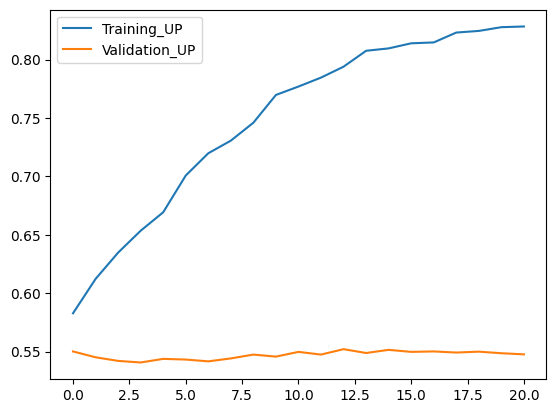

In [90]:
plt.plot(his_up.history['accuracy'], label='Training_UP')
plt.plot(his_up.history['val_accuracy'], label='Validation_UP')
plt.legend()
plt.show()

In [43]:
len(validation_data['upSignals'])

5300

In [44]:
validation_data['upSignals'].count(1)

2428

In [45]:
validation_data['upSignals'].count(0)

2872